In [1]:
# -*- coding: utf-8 -*-
"""
@author: Rukang Xu
"""

'\n@author: Rukang Xu\n'

In [2]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



## Notes for package installation:
> When specifying `-e` or `develop`, MMDetection is installed on **dev** mode , any local modifications made to the code will take effect without reinstallation.

In [3]:
# Check Pytorch installation on Virtual Machine of Google
torch_version = ''
try:
  import torch, torchvision
  torch_version = torch.__version__
  print(torch.__version__, torch.cuda.is_available())
except ImportError as error:
  # Output expected ImportErrors.
  print(error.__class__.__name__ + ": " + error.message)
  # install dependencies: (use cu101 because colab has CUDA 10.1)
  # !pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
  # install dependencies: (use cu111 because colab has CUDA 11.1)
  !pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
  import torch, torchvision
  torch_version = torch.__version__
  print(torch.__version__, torch.cuda.is_available())


1.10.0+cu111 False


In [4]:
# check the gpu device being used
if torch.cuda.is_available():
  print('the device name is:')
  print(torch.cuda.get_device_name(torch.cuda.current_device()))
  print('Memory Usage:')
  print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
  print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
else:
  print('No gpu device is available.')

No gpu device is available.


In [5]:
cur_torch_version, cur_cuda_version = torch_version.split('+')[0], torch_version.split('+')[1]
cur_torch_version = ''.join(('torch', cur_torch_version))
# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full==1.4.0 -f "https://download.openmmlab.com/mmcv/dist/"$cur_cuda_version"/"$cur_torch_version"/index.html"

# Install mmdetection
# !rm -rf mmdetection
# !git clone https://github.com/open-mmlab/mmdetection.git
# %cd mmdetection
!rm -rf CBNetV2
!git clone https://github.com/VDIGPKU/CBNetV2.git 
%cd CBNetV2


!pip install -e .

# install pandas to deal with current dataset
!pip install pandas

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow

# install opencv
!pip install opencv-python

# install pyyaml
!pip install pyyaml

# install pathlib2, an alternative to os.path
!pip install pathlib2

# install tdam which displays nice progress bars, ipywidgets for tqdm's notebook support
!pip install tqdm
!pip install ipywidgets

# install sklearn
!pip install scikit-learn

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 58.0 MB 52 kB/s 
     |████████████████████████████████| 190 kB 11.4 MB/s 
Cloning into 'CBNetV2'...
remote: Enumerating objects: 19187, done.
remote: Counting objects: 100% (19187/19187), done.
remote: Compressing objects: 100% (5481/5481), done.
remote: Total 19187 (delta 13641), reused 19129 (delta 13608), pack-reused 0
Receiving objects: 100% (19187/19187), 22.18 MiB | 15.68 MiB/s, done.
Resolving deltas: 100% (13641/13641), done.
/content/CBNetV2
Obtaining file:///content/CBNetV2
     |████████████████████████████████| 431 kB 25.1 MB/s 
  Running setup.py develop for mmdet


In [6]:
# check TensorFlow installation when it is needed
# import tensorflow as tf
# tf.test.gpu_device_name()
# Standard output is '/device:GPU:0'

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

# import other useful python packages
import pathlib2
import os
print(f'the current work dir is: {os.getcwd()}')
import time
import os.path as osp
import PIL
import numpy as np
import pandas as pd
import mmcv
import matplotlib.pyplot as plt
import cv2

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
2.14.0
11.1
GCC 7.3
the current work dir is: /content/CBNetV2


## Download a pretrained model to the checkpoints
1. backbone:
  - swin transformer
    - https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22k.pth from [reference link](https://github.com/VDIGPKU/CBNetV2/issues/45)
    - https://github.com/CBNetwork/storage/releases/download/v1.0.0/cascade_mask_rcnn_cbv2_swin_small_patch4_window7_mstrain_400-1400_adamw_3x_coco.pth.zip

## Macros

In [7]:
from easydict import EasyDict as edict

__C = edict()
local_cfg = __C

__C.USE_GOOGLE_DRIVE = False
__C.CURRENT_DIR = pathlib2.Path.cwd()
print("current dir: ", __C.CURRENT_DIR.as_posix())
# the highest level dir that holds all relevant files
__C.PROJECT_DIR = __C.CURRENT_DIR.parent
print("project dir: ", __C.PROJECT_DIR.as_posix())
__C.DATA_DIR = __C.PROJECT_DIR / 'data'
print("dataset dir: ", __C.DATA_DIR.as_posix())

__C.SPLIT_IN_THREE = True
__C.TEST_SIZE = 0.3
__C.VAL_SIZE = 1/float(6)
__C.RANDOM_STATE = 42
__C.FEATURES = ['id', 'annotation', 'width', 'height', 'cell_type']

__C.HEIGHT, __C.WIDTH = 520, 704

current dir:  /content/CBNetV2
project dir:  /content
dataset dir:  /content/data


## Load LIVCell dataset and dataset for competition onto Google Virtual Machine
### From Google Drive (Deprecated in terms of competition)
If you select this approach for data preparation, please **skip the next code blocks for data preparation directly from Kaggle**.

You can use the drive module from google.colab to mount your entire Google Drive to Colab by:

1. Executing the below code which will provide you with an authentication link

2. Open the link

3. Choose the Google account whose Drive you want to mount

4. Allow Google Drive Stream access to your Google Account

5. Copy the code displayed, paste it in the text box as shown below, and press Enter

6. Once the Drive is mounted, you’ll get the message “Mounted at /content/gdrive”, and you’ll be able to browse through the contents of your Drive from the file-explorer pane.

### From Kaggle (currently not normal!)
This is an alternative to data preparation from Google Drive.

To download datasets from Kaggle, you first need a Kaggle account and an API token. 

1. To generate your API token, go to “My Account”, then “Create New API Token”. 

2. Open the kaggle.json file, and copy its contents. It should be in the form of {"username":"########", "key":"################################"}.

3. Then run the below commands in the first cell:

4. Once the kaggle.json file has been created in Colab, and the Kaggle library has been installed, you can search for a dataset using commands in the second cell

5. And then download the dataset using commands in the third cell

In [8]:
# set up the new dir for storing data
!mkdir -p /content/data
!mkdir -p /content/data/cache
!mkdir -p /content/data/cache/livecell_images

In [9]:
local_cfg.USE_GOOGLE_DRIVE = False
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
!echo '{"username":"rukangxu","key":"291de73a9aefdbca32fc86f9d483088b"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install --upgrade --force-reinstall --no-deps kaggle #install the kaggle library**

     |████████████████████████████████| 58 kB 5.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=209244fb750f2b40c75d99e91e4d880ffd8cc606dbe3960f7ea4d6fd9018ef90
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [10]:
# to check if kaggle is installed
!kaggle datasets list

ref                                                         title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nkitgupta/jigsaw-regression-based-data                      Jigsaw Regression Based Data                         3GB  2022-01-10 06:29:59            619         56  0.88235295       
yamqwe/omicron-covid19-variant-daily-cases                  Omicron daily cases by country (COVID-19 variant)  432KB  2022-01-30 09:11:54          11190        506  1.0              
prasertk/netflix-subscription-price-in-different-countries  Netflix subscription fee in different countries      3KB  2022-01-15 07:06:09           1458         42  1.0              
yasserh/wine-quality-dataset                                Wine Quality Dataset     

In [11]:
# TODO current use of kaggle downloading function is with fault!!
# See the links: https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/
print('Start downloading dataset from Kaggle to Virtual Machine...')
tic_dl = time.time()
!kaggle competitions download -c sartorius-cell-instance-segmentation -p /content/
!unzip /content/sartorius-cell-instance-segmentation.zip -d /content/data/
print(('Done (t={:0.2f}s)'.format(time.time() - tic_dl)))

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/data/LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_1.tif  
  inflating: /content/data/LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_2.tif  
  inflating: /content/data/LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_3.tif  
  inflating: /content/data/LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_4.tif  
  inflating: /content/data/LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d08h00m_1.tif  
  inflating: /content/data/LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d08h00m_2.tif  
  inflating: /content/data/LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d08h00m_3.tif  
  inflating: /content/data/LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d08h00m_4.tif

In [12]:
!rm /content/sartorius-cell-instance-segmentation.zip

## Train a detector on LIVECell dataset and dataset for competition

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Support a new dataset

There are three ways to support a new dataset in MMDetection: 
  1. reorganize the dataset into COCO format.
  2. reorganize the dataset into a middle format.
  3. implement a new dataset.

Usually we recommend to use the first two methods which are usually easier than the third.

In this tutorial, we gives an example that converting the data into the format of existing datasets like COCO, VOC, etc. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/tutorials/new_dataset.html#).

#### Check the dataset

In [13]:
# Check the directory structure of LIVECell and competition dataset
# Here, we first check the dataset mounted in Google Drive.

# Install tree first
# TODO this following origin file may be not general to each case
!apt-get -q install tree
#!tree /content/gdrive/MyDrive/rkx_cell_is/data -L 1
!tree /content/data -L 1

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (165 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
/content/data
├── cache
├── LIVECell_dataset_2021
├── sample_submission.csv
├── test
├── train
├── train.csv
└── train_semi_supervised

5 directories, 2 files


In [14]:
livecell_ds_path = local_cfg.DATA_DIR / 'LIVECell_dataset_2021'
print("livecell dataset dir: ", livecell_ds_path.as_posix())
# TODO the following syntax "livecell_ds_path.iterdir()" seems like to 
# be not deterministic about the order of returned element
# Please check it!
livecell_ds_imgs_path = None
livecell_ds_annots_path = None
livecell_ds_path_list = [x for x in livecell_ds_path.iterdir() if x.is_dir()]
for path_item in livecell_ds_path_list:
  if 'annotations' in path_item.as_posix():
    livecell_ds_annots_path = path_item
  else:
    livecell_ds_imgs_path = path_item

print("livecell dataset annot dir: ", livecell_ds_annots_path.as_posix())
print("livecell dataset image dir: ", livecell_ds_imgs_path.as_posix())

livecell_train_meta_path = livecell_ds_annots_path / 'LIVECell' / 'livecell_coco_train.json'
livecell_val_meta_path = livecell_ds_annots_path / 'LIVECell' / 'livecell_coco_val.json'
livecell_test_meta_path = livecell_ds_annots_path / 'LIVECell' / 'livecell_coco_test.json'

livecell_train_val_img_path = livecell_ds_imgs_path / 'livecell_train_val_images'
livecell_test_img_path = livecell_ds_imgs_path / 'livecell_test_images'

livecell dataset dir:  /content/data/LIVECell_dataset_2021
livecell dataset annot dir:  /content/data/LIVECell_dataset_2021/annotations
livecell dataset image dir:  /content/data/LIVECell_dataset_2021/images


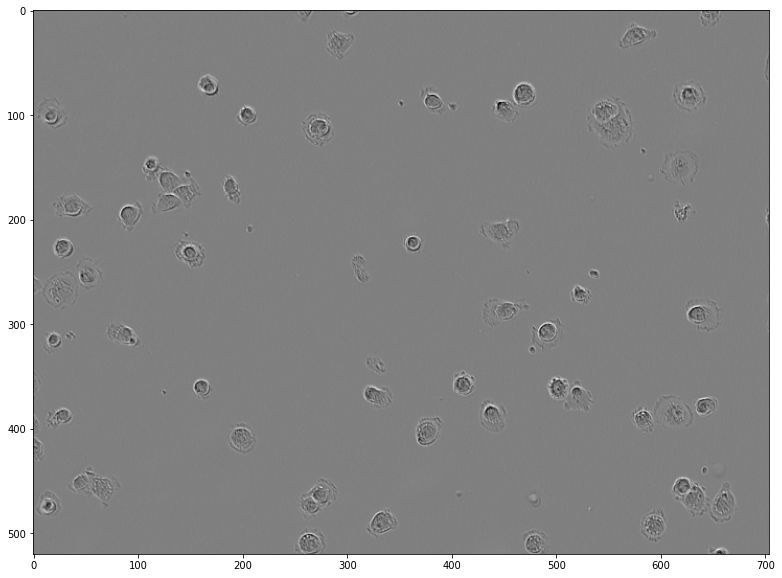

In [15]:
# Let's take a look at the dataset image

img = mmcv.imread((livecell_test_img_path / 'A172' / 'A172_Phase_C7_1_00d00h00m_1.tif').as_posix())
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

#### Conversion to desired dataset format MMDetection accepts
Since MMDetection only supports evaluating mask AP of dataset in COCO format for now, we need to read annotations of each image and convert them into COCO format MMDetection accepts is as below:

```json
{
    "images": [image],
    "annotations": [annotation],
    "categories": [category]
}

image = {
    "id": int,
    "width": int,
    "height": int,
    "file_name": str,
}
annotation = {
    "id": int,
    "image_id": int,
    "category_id": int,
    "segmentation": RLE or [polygon],
    "area": float,
    "bbox": [x,y,width,height],
    "iscrowd": 0 or 1,
}
categories = [{
    "id": int,
    "name": str,
    "supercategory": str,
}]
```

**Conversion of LIVECell dataset**

In [ ]:
# convert the annotations of livecell dataset from its own format to
# coco format MMDetection accepts
def convert_livecell_to_coco(ann_file, out_file, image_prefix):
    file_format = ann_file.split('.')[-1]
    data_infos = mmcv.load(ann_file, file_format=file_format)

    annotations = []
    images = []
    obj_count = 0
    # dir_patt_obj = re.compile(r"[a-zA-Z0-9]+", flags=0)
    
    for par_key, par_value in mmcv.track_iter_progress(data_infos.items()):
      if par_key == 'images':
        for value in par_value:
          # match_res = dir_patt_obj.match(filename)
          # filtered_dir = match_res.group(0)
          # img_path = (image_prefix / filtered_dir / filename).as_posix()
          # height, width = mmcv.imread(img_path).shape[:2]
          images.append(dict(
            id=int(value['id']),
            file_name=value['file_name'],
            height=int(value['height']),
            width=int(value['width'])))
      elif par_key == 'annotations':
        for value in par_value.values():
          data_anno = dict(
                image_id=int(value['image_id']),
                #id=int(value['id']),
                id=obj_count,
                category_id=1,
                bbox=value['bbox'],
                area=float(value['area']),
                segmentation=value['segmentation'],
                iscrowd=0)
          annotations.append(data_anno)
          obj_count += 1
      elif par_key == 'categories':
        categories=par_value
      else:
        pass
    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=categories)
    mmcv.dump(coco_format_json, out_file) 
    return coco_format_json # TODO this return line to be deprecated in the future!


In [ ]:
# TODO the 'train_result_dict', 'val_result_dict', 'test_result_dict' should be removed when there is no returned value in the future!
# TODO please change the suffix of the filename to '.json' if any problem happens when loading or dumping using mmdetection I/O API!

livecell_train_meta_path = str(livecell_train_meta_path)
train_out_file = str(local_cfg.DATA_DIR / 'cache' / 'livecell_coco_train.json')
livecell_val_meta_path = str(livecell_val_meta_path)
val_out_file = str(local_cfg.DATA_DIR / 'cache' / 'livecell_coco_val.json')
livecell_test_meta_path = str(livecell_test_meta_path)
test_out_file = str(local_cfg.DATA_DIR / 'cache' / 'livecell_coco_test.json')

# convert train annotations
train_result_dict = convert_livecell_to_coco(livecell_train_meta_path, train_out_file, livecell_train_val_img_path)
# convert val annotations
val_result_dict = convert_livecell_to_coco(livecell_val_meta_path, val_out_file, livecell_train_val_img_path)
# convert test annotations
test_result_dict = convert_livecell_to_coco(livecell_test_meta_path, test_out_file, livecell_test_img_path)


In [ ]:
# check the results
# TODO this checking code block to be deprecated in the future!
import pprint
print(train_result_dict.keys())
print('-----------------')
pprint.pprint(train_result_dict['images'][0])
print('-----------------')
pprint.pprint(train_result_dict['annotations'][0])
print('-----------------')
pprint.pprint(train_result_dict['categories'])
del train_result_dict
del val_result_dict
del test_result_dict

**Conversion of Current dataset**

In [16]:
# convert the annotations of current dataset from its own format to
# coco format MMDetection accepts

train_cur_ds_path = local_cfg.DATA_DIR / 'train.csv'
df_train_cur_ds = pd.read_csv(train_cur_ds_path)
# check the current dataset
df_train_cur_ds.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [18]:
from sklearn.model_selection import train_test_split
from pycocotools import mask as COCOmask


CELL_TYPES = {'shsy5y':1, 'astro':2, 'cort':3}
np.random.seed(local_cfg.RANDOM_STATE)

# split the df according to id
class CompetitionData():
  """
  construct the class object that deals with the annotation metadata
  :param image_set: string name of split
  :param df_cur_ds: pd.DataFrame dataframe with relevant features
  """
  def __init__(self, df_cur_ds):
    self._df_cur_ds = df_cur_ds
    self._ids = None
    self._classes = ('shsy5y', 'astro', 'cort')
    self._shsy5y_ids = None
    self._astro_ids = None
    self._cort_ids = None
    self._train_ids = None
    self._val_ids = None
    self._test_ids = None
    self.register_ids()
    self.cache_path = local_cfg.DATA_DIR / 'cache'

  @property
  def ids(self):
    return self._ids

  @property
  def train_ids(self):
    return self._train_ids

  @property
  def val_ids(self):
    return self._val_ids

  @property
  def test_ids(self):
    return self._test_ids  

  @property
  def head(self):
    return self._df_cur_ds.head()

  def _split_ids_tool(self, class_ids, split_in_three=True):
    if split_in_three:
      big_train_ids, test_ids = train_test_split(class_ids, 
                              test_size=local_cfg.TEST_SIZE, 
                              random_state=local_cfg.RANDOM_STATE)
      train_ids, val_ids = train_test_split(big_train_ids, 
                            test_size=local_cfg.VAL_SIZE, 
                            random_state=local_cfg.RANDOM_STATE)
      return train_ids, val_ids, test_ids 
    else:
      # hard code the test_size as 0.2 for consistence among group members
      train_ids, val_ids = train_test_split(class_ids, 
                            test_size=0.2, 
                            random_state=local_cfg.RANDOM_STATE)
      return train_ids, val_ids

  def split_ids(self, split_in_three=True):
    if split_in_three:
      shsy5y_train_ids, shsy5y_val_ids, shsy5y_test_ids = \
          self._split_ids_tool(self._shsy5y_ids,split_in_three=split_in_three)
      astro_train_ids, astro_val_ids, astro_test_ids = \
          self._split_ids_tool(self._astro_ids,split_in_three=split_in_three)
      cort_train_ids, cort_val_ids, cort_test_ids = \
          self._split_ids_tool(self._cort_ids,split_in_three=split_in_three)
      self._train_ids = np.concatenate((shsy5y_train_ids, astro_train_ids, cort_train_ids), axis=0)
      np.random.shuffle(self._train_ids)
      self._val_ids = np.concatenate((shsy5y_val_ids, astro_val_ids, cort_val_ids), axis=0)
      np.random.shuffle(self._val_ids)
      self._test_ids = np.concatenate((shsy5y_test_ids, astro_test_ids, cort_test_ids), axis=0)
      np.random.shuffle(self._test_ids)
    else:
      shsy5y_train_ids, shsy5y_val_ids = \
          self._split_ids_tool(self._shsy5y_ids,split_in_three=split_in_three)
      astro_train_ids, astro_val_ids = \
          self._split_ids_tool(self._astro_ids,split_in_three=split_in_three)
      cort_train_ids, cort_val_ids = \
          self._split_ids_tool(self._cort_ids,split_in_three=split_in_three)
      self._train_ids = np.concatenate((shsy5y_train_ids, astro_train_ids, cort_train_ids), axis=0)
      np.random.shuffle(self._train_ids)
      self._val_ids = np.concatenate((shsy5y_val_ids, astro_val_ids, cort_val_ids), axis=0)
      np.random.shuffle(self._val_ids)

  def get_annot_in_coco(self, mode = None):
    """
    get the processed annotation dataset based on coco format according to mode
    :param mode: string name of split
    :return: pd.DataFrame proessed dataframe
    """
    if mode == 'train':
      cache_file = self.cache_path / 'competition_coco_train.json'
      if osp.exists(cache_file.as_posix()):
        df_train = pd.read_json(cache_file)
        print(f'training annots in coco loaded from {cache_file}')
        return df_train
      df_train = self._df_cur_ds[np.array([x in self._train_ids for x in self._df_cur_ds['id'].to_numpy()])]
      df_train['area'] = pd.Series(dtype=np.float64)
      df_train['bbox'] = pd.Series()
      df_train['poly'] = pd.Series()
      for id in self._train_ids:
        sampled_ids = df_train.index[df_train['id']==id]  # .tolist()
        temp_annot_series = df_train.loc[sampled_ids, 'annotation']
        polys, bboxes, areas = self.group2mmdetect(temp_annot_series)
        df_train.loc[sampled_ids,'poly'] = pd.Series(polys, index=sampled_ids)
        df_train.loc[sampled_ids,'bbox'] = pd.Series(bboxes.tolist(), index=sampled_ids)
        df_train.loc[sampled_ids,'area'] = pd.Series(areas, index=sampled_ids)
      df_train.to_json(str(cache_file))
      return df_train
    elif mode == 'val':
      cache_file = self.cache_path / 'competition_coco_val.json'
      if osp.exists(cache_file.as_posix()):
        df_val = pd.read_json(cache_file)
        print(f'val annots in coco loaded from {cache_file}')
        return df_val
      df_val = self._df_cur_ds[np.array([x in self._val_ids for x in self._df_cur_ds['id'].to_numpy()])]
      df_val['area'] = pd.Series(dtype=np.float64)
      df_val['bbox'] = pd.Series()
      df_val['poly'] = pd.Series()
      for id in self._val_ids:
        sampled_ids = df_val.index[df_val['id']==id]  # .tolist()
        temp_annot_series = df_val.loc[sampled_ids, 'annotation']
        polys, bboxes, areas = self.group2mmdetect(temp_annot_series)
        df_val.loc[sampled_ids,'poly'] = pd.Series(polys, index=sampled_ids)
        df_val.loc[sampled_ids,'bbox'] = pd.Series(bboxes.tolist(), index=sampled_ids)
        df_val.loc[sampled_ids,'area'] = pd.Series(areas, index=sampled_ids)
      df_val.to_json(str(cache_file))
      return df_val
    elif mode == 'test':
      assert self._test_ids is not None, "test mode should not be activated when there is no test split"
      cache_file = self.cache_path / 'competition_coco_test.json'
      if osp.exists(cache_file.as_posix()):
        df_test = pd.read_json(cache_file)
        print(f'test annots in coco loaded from {cache_file}')
        return df_test
      df_test = self._df_cur_ds[np.array([x in self._test_ids for x in self._df_cur_ds['id'].to_numpy()])]
      df_test['area'] = pd.Series(dtype=np.float64)
      df_test['bbox'] = pd.Series()
      df_test['poly'] = pd.Series()
      for id in self._test_ids:
        sampled_ids = df_test.index[df_test['id']==id]  # .tolist()
        temp_annot_series = df_test.loc[sampled_ids, 'annotation']
        polys, bboxes, areas = self.group2mmdetect(temp_annot_series)
        df_test.loc[sampled_ids,'poly'] = pd.Series(polys, index=sampled_ids)
        df_test.loc[sampled_ids,'bbox'] = pd.Series(bboxes.tolist(), index=sampled_ids)
        df_test.loc[sampled_ids,'area'] = pd.Series(areas, index=sampled_ids)
      df_test.to_json(str(cache_file))
      return df_test

  def convert_to_coco(self, df_split, outfile):
    """
    convert the dataframe that holds the annotation dataset to dict complies to coco format and save it
    :param df_split: pd.DataFrame dataframe according to split
    :param outfile: path for saving
    :return: dict dict that complies to coco format
    """
    annotations = []
    images = []
    obj_count = 0
    has_duplicates = df_split['id'].duplicated(keep='first')
    df_unique = df_split[~has_duplicates]  # .reset_index(drop=True)
    for ind, row in df_unique.iterrows():
      # id is image_id, which is extracted from the annot_ids based
      # on the the location of unqiue image_id in the annot_ids
      id = int(ind)
      file_name = '.'.join((row['id'], 'png'))
      height = int(row['height'])
      width = int(row['width'])
      images.append(
          dict(
              id = id, # consistent with indices in df_split, i.e., df_cur_ds
              file_name = file_name,
              height = height,
              width = width
          )
      )
    for ind, row in df_split.iterrows():
      image_id = int(df_unique.index[df_unique['id'].to_numpy() == row['id']][0])
      id = obj_count
      category_id = int(CELL_TYPES[row['cell_type']])
      annotations.append(
          dict(
              id = id,
              image_id = image_id,
              category_id = category_id,
              segmentation = row['poly'],
              area = float(row['area']),
              bbox = row['bbox'],
              iscrowd = 0
          )
      )
      obj_count += 1
    coco_format_json = dict(
        images = images,
        annotations = annotations,
        categories = [{'supercategory': 'cell', 'id': 1, 'name': 'shsy5y'},
                {'supercategory': 'cell', 'id': 2, 'name': 'astro'},
                {'supercategory': 'cell', 'id': 3, 'name': 'cort'}]
    )
    print('the highest-level keys of metadata is:')
    print(coco_format_json.keys())
    print('the keys of images in metadata is:')
    print(coco_format_json['images'][0].keys())
    print('the keys of annotations in metadata is:')
    print(coco_format_json['annotations'][0].keys())
    print('the keys of categories in metadata is:')
    print(coco_format_json['categories'][0].keys())

    mmcv.dump(coco_format_json, outfile)
    return coco_format_json

  def register_ids(self):
    has_duplicates = self._df_cur_ds['id'].duplicated(keep='first')
    unique_ids_classes = self._df_cur_ds[~has_duplicates].loc[:, ['id', 'cell_type']]
    self._ids = unique_ids_classes.loc[:, 'id'].to_numpy(dtype=str)
    self._shsy5y_ids = unique_ids_classes[unique_ids_classes['cell_type']==self._classes[0]].loc[:, 'id'].to_numpy(dtype=str)
    self._astro_ids = unique_ids_classes[unique_ids_classes['cell_type']==self._classes[1]].loc[:, 'id'].to_numpy(dtype=str)
    self._cort_ids = unique_ids_classes[unique_ids_classes['cell_type']==self._classes[2]].loc[:, 'id'].to_numpy(dtype=str)

  def _kaggle2coco(self, kaggle_rle, h, w):
    if not len(kaggle_rle):
      # return {'counts': [h * w], 'size': [h ,w]}
      return {'counts': [h * w], 'size': [w, h]}
    roll2 = np.roll(kaggle_rle, 2)
    roll2[:2] = 1

    roll1 = np.roll(kaggle_rle, 1)
    roll1[:1] = 0

    if h * w != kaggle_rle[-1] + kaggle_rle[-2] - 1:
      # when the last pixel included is not the bottom right
      shift = 1
      end_value = h * w - kaggle_rle[-1] - kaggle_rle[-2] + 1
    else:
      shift = 0
      end_value = 0
    coco_rle = np.full(len(kaggle_rle) + shift, end_value)
    coco_rle[:len(coco_rle) - shift] = kaggle_rle.copy()
    coco_rle[:len(coco_rle) - shift:2] = (kaggle_rle - roll1 - roll2)[::2].copy()
    # reason for the arrangement of [w, h] instead of [h, w]:
    # the rle here is column-major other than row-major accepted in coco
    # return {'counts': coco_rle.tolist(), 'size': [h ,w]}
    return {'counts': coco_rle.tolist(), 'size': [w, h]} # !the original rle is already numbered from left to right first, then top to bottom!

  def _get_poly_from_mask(self, mask):
    """
    get the polygon from the binary mask
    :param mask: np.ndarray binary mask
    :return: list polygon as list
    """
    contours, _ = cv2.findContours(mask.T, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # !the original rle is already numbered from left to right first, then top to bottom!
    segmentation = []
    for contour in contours:
      # A valid polygon should have at least 3 points
      if contour.size >= 6:
        # as possibly needed by mmdetection in terms of float type
        segmentation.append(list(map(float, contour.flatten().tolist())))
    return segmentation

  def group2mmdetect(self, annot_series):
    """
    convert the grouped annotation infos to format mmdetection accepts
    :param df_cur_ds: pd.Series the annotation series
    :return: np.ndarray bounding boxes and areas
    """
    height, width = local_cfg.HEIGHT, local_cfg.WIDTH
    uncompressed_rles = annot_series.apply(lambda x: self._kaggle2coco(list(map(int, x.split())), height, width)).tolist()
    rles = COCOmask.frPyObjects(uncompressed_rles, height, width)  # !the original rle is already numbered from left to right first, then top to bottom!
    masks = COCOmask.decode(rles)  # (w, h, number_of_total_cells) <= !the original rle is already numbered from left to right first, then top to bottom!
    # print(f'the shape of masks is: {masks.shape}')
    temp_masks_lst = list(np.transpose(masks, (2,0,1)))
    # print(f'  the shape of one sample from masks list is: {temp_masks_lst[0].shape}')
    # print('--------------------')
    polys = list(map(self._get_poly_from_mask, temp_masks_lst)) # form: [[[...]], [[...]], ...]
    # print(f'there are {len(polys[0][0])} coordinates for the first annotation')
    # print('--------------------')
    bboxes = COCOmask.toBbox(COCOmask.encode(np.asfortranarray(masks.astype(np.uint8))))
    temp_xs = bboxes[:, 0].copy()
    temp_ws = bboxes[:, 2].copy()
    bboxes[:, 0] = bboxes[:, 1]
    bboxes[:, 2] = bboxes[:, 3]
    bboxes[:, 1] = temp_xs
    bboxes[:, 3] = temp_ws
    areas = COCOmask.area(rles)
    return polys, bboxes, areas

  def _get_poly_from_mask_v2(self, mask):
    """
    get the polygon from the binary mask
    :param mask: np.ndarray binary mask
    :return: list polygon as list
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # !the original rle is already numbered from left to right first, then top to bottom!
    segmentation = []
    for contour in contours:
      # A valid polygon should have at least 3 points
      if contour.size >= 6:
        # as possibly needed by mmdetection in terms of float type
        segmentation.append(list(map(float, contour.flatten().tolist())))
    return segmentation

  def rle2mask(self, rle, shape=[520, 704]):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    starts, lengths = [np.asarray(x, dtype=int) for x in (rle[0:][::2], rle[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)   

  def group2mmdetect_v2(self, annot_series):
    """
    convert the grouped annotation infos to format mmdetection accepts
    :param df_cur_ds: pd.Series the annotation series
    :return: np.ndarray bounding boxes and areas
    """
    height, width = local_cfg.HEIGHT, local_cfg.WIDTH
    uncompressed_rles = annot_series.apply(lambda x: list(map(int, x.split()))).tolist()
    masks = list(map(rle2mask, uncompressed_rles))
    print(f'the shape of masks is: {masks[0].shape}')
    # print(f'  the shape of one sample from masks list is: {temp_masks_lst[0].shape}')
    # print('--------------------')
    polys = list(map(self._get_poly_from_mask_v2, masks)) # form: [[[...]], [[...]], ...]
    # print(f'there are {len(polys[0][0])} coordinates for the first annotation')
    # print('--------------------')
    bboxes = COCOmask.toBbox(COCOmask.encode(np.ascontiguousarray(masks.astype(np.uint8))))
    temp_xs = bboxes[:, 0].copy()
    temp_ws = bboxes[:, 2].copy()
    bboxes[:, 0] = bboxes[:, 1]
    bboxes[:, 2] = bboxes[:, 3]
    bboxes[:, 1] = temp_xs
    bboxes[:, 3] = temp_ws
    areas = COCOmask.area(rles)
    return polys, bboxes, areas

In [ ]:
from sklearn.model_selection import train_test_split
from pycocotools import mask as COCOmask
from tqdm import tqdm
import itertools

np.random.seed(local_cfg.RANDOM_STATE)

# split the df according to id
class CompetitionData():
  """
  construct the class object that deals with the annotation metadata
  :param image_set: string name of split
  :param df_cur_ds: pd.DataFrame dataframe with relevant features
  """
  def __init__(self, df_cur_ds):
    self._df_cur_ds = df_cur_ds
    self._ids = None
    self._classes = ('shsy5y', 'astro', 'cort')
    self._shsy5y_ids = None
    self._astro_ids = None
    self._cort_ids = None
    self._train_ids = None
    self._val_ids = None
    self._test_ids = None
    self.register_ids()
    self.cache_path = local_cfg.DATA_DIR / 'cache'

  @property
  def ids(self):
    return self._ids

  @property
  def train_ids(self):
    return self._train_ids

  @property
  def val_ids(self):
    return self._val_ids

  @property
  def test_ids(self):
    return self._test_ids  

  @property
  def head(self):
    return self._df_cur_ds.head()

  def _split_ids_tool(self, class_ids, split_in_three=True):
    if split_in_three:
      big_train_ids, test_ids = train_test_split(class_ids, 
                              test_size=local_cfg.TEST_SIZE, 
                              random_state=local_cfg.RANDOM_STATE)
      train_ids, val_ids = train_test_split(big_train_ids, 
                            test_size=local_cfg.VAL_SIZE, 
                            random_state=local_cfg.RANDOM_STATE)
      return train_ids, val_ids, test_ids 
    else:
      # hard code the test_size as 0.2 for consistence among group members
      train_ids, val_ids = train_test_split(class_ids, 
                            test_size=0.2, 
                            random_state=local_cfg.RANDOM_STATE)
      return train_ids, val_ids

  def split_ids(self, split_in_three=True):
    if split_in_three:
      shsy5y_train_ids, shsy5y_val_ids, shsy5y_test_ids = \
          self._split_ids_tool(self._shsy5y_ids,split_in_three=split_in_three)
      astro_train_ids, astro_val_ids, astro_test_ids = \
          self._split_ids_tool(self._astro_ids,split_in_three=split_in_three)
      cort_train_ids, cort_val_ids, cort_test_ids = \
          self._split_ids_tool(self._cort_ids,split_in_three=split_in_three)
      self._train_ids = np.concatenate((shsy5y_train_ids, astro_train_ids, cort_train_ids), axis=0)
      np.random.shuffle(self._train_ids)
      self._val_ids = np.concatenate((shsy5y_val_ids, astro_val_ids, cort_val_ids), axis=0)
      np.random.shuffle(self._val_ids)
      self._test_ids = np.concatenate((shsy5y_test_ids, astro_test_ids, cort_test_ids), axis=0)
      np.random.shuffle(self._test_ids)
    else:
      shsy5y_train_ids, shsy5y_val_ids = \
          self._split_ids_tool(self._shsy5y_ids,split_in_three=split_in_three)
      astro_train_ids, astro_val_ids = \
          self._split_ids_tool(self._astro_ids,split_in_three=split_in_three)
      cort_train_ids, cort_val_ids = \
          self._split_ids_tool(self._cort_ids,split_in_three=split_in_three)
      self._train_ids = np.concatenate((shsy5y_train_ids, astro_train_ids, cort_train_ids), axis=0)
      np.random.shuffle(self._train_ids)
      self._val_ids = np.concatenate((shsy5y_val_ids, astro_val_ids, cort_val_ids), axis=0)
      np.random.shuffle(self._val_ids)

  def rle_decode(self, mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

  def binary_mask_to_rle(self, binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle
  
  def coco_structure(self, train_df, outfile):
    cat_ids = {name:id+1 for id, name in enumerate(train_df.cell_type.unique())}    
    cats =[{'name':name, 'id':id} for name,id in cat_ids.items()]
    images = [{'id':id, 'width':row.width, 'height':row.height, 'file_name':f'{id}.png'} for id,row in train_df.groupby('id').agg('first').iterrows()]
    annotations=[]
    for idx, row in tqdm(train_df.iterrows()):
        mk = self.rle_decode(row.annotation, (row.height, row.width))
        ys, xs = np.where(mk)
        x1, x2 = min(xs), max(xs)
        y1, y2 = min(ys), max(ys)
        enc = self.binary_mask_to_rle(mk)
        seg = {
            'segmentation':enc, 
            'bbox': [int(x1), int(y1), int(x2-x1+1), int(y2-y1+1)],
            'area': int(np.sum(mk)),
            'image_id':row.id, 
            'category_id':cat_ids[row.cell_type], 
            'iscrowd':0, 
            'id':idx
        }
        annotations.append(seg)
    coco_format_json = {'categories':cats, 'images':images, 'annotations':annotations}
    print('the highest-level keys of metadata is:')
    print(coco_format_json.keys())
    print('the keys of images in metadata is:')
    print(coco_format_json['images'][0].keys())
    print('the keys of annotations in metadata is:')
    print(coco_format_json['annotations'][0].keys())
    print('the keys of categories in metadata is:')
    print(coco_format_json['categories'][0].keys())
    mmcv.dump(coco_format_json, outfile)
    return coco_format_json

  def register_ids(self):
    has_duplicates = self._df_cur_ds['id'].duplicated(keep='first')
    unique_ids_classes = self._df_cur_ds[~has_duplicates].loc[:, ['id', 'cell_type']]
    self._ids = unique_ids_classes.loc[:, 'id'].to_numpy(dtype=str)
    self._shsy5y_ids = unique_ids_classes[unique_ids_classes['cell_type']==self._classes[0]].loc[:, 'id'].to_numpy(dtype=str)
    self._astro_ids = unique_ids_classes[unique_ids_classes['cell_type']==self._classes[1]].loc[:, 'id'].to_numpy(dtype=str)
    self._cort_ids = unique_ids_classes[unique_ids_classes['cell_type']==self._classes[2]].loc[:, 'id'].to_numpy(dtype=str)



In [19]:
# TODO to use the dataframe with relevant features: c_data = CompetitionData(df_train_cur_ds.loc[:, local_cfg.FEATURES])

c_data = CompetitionData(df_train_cur_ds)
c_data.head

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [20]:
c_data.split_ids(split_in_three=False)  #only keep the training and validation ds

In [21]:
# validate the splitting
# print('the size of training, validation and testing dataset are separately:')
# print(c_data.train_ids.shape, c_data.val_ids.shape, c_data.test_ids.shape)
print('the size of training and validation dataset are separately:')
print(c_data.train_ids.shape, c_data.val_ids.shape)

the size of training and validation dataset are separately:
(484,) (122,)


In [ ]:
df_train = df_train_cur_ds[np.array([x in c_data.train_ids for x in df_train_cur_ds['id'].to_numpy()])]
# df_train.shape
train_out_file = str(local_cfg.DATA_DIR / 'competition_coco_train.json')
coco_train_json = c_data.coco_structure(df_train, train_out_file)
#check the processed dataframe holding the extra columns for area, bbox and polygon segmentation
# df_train.head()

(59655, 9)

In [ ]:
# TODO to remove the references "coco_train_json", "coco_val_json", "coco_test_json" in the future for sake of memory
train_out_file = str(local_cfg.DATA_DIR / 'competition_in_coco_train.json')
coco_train_json = c_data.convert_to_coco(df_train, train_out_file)

the highest-level keys of metadata is:
dict_keys(['images', 'annotations', 'categories'])
the keys of images in metadata is:
dict_keys(['id', 'file_name', 'height', 'width'])
the keys of annotations in metadata is:
dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd'])
the keys of categories in metadata is:
dict_keys(['supercategory', 'id', 'name'])


In [ ]:
# check the results
# TODO this checking code block to be deprecated in the future!
import pprint
print(coco_train_json.keys())
print('-----------------')
pprint.pprint(coco_train_json['images'][400])
print('-----------------')
pprint.pprint(coco_train_json['annotations'][40000])
print('-----------------')
pprint.pprint(coco_train_json['categories'])

dict_keys(['categories', 'images', 'annotations'])
-----------------
{'file_name': 'd5c06777eee7.png',
 'height': 520,
 'id': 'd5c06777eee7',
 'width': 704}
-----------------
{'area': 1077,
 'bbox': [282, 311, 66, 64],
 'category_id': 2,
 'id': 49696,
 'image_id': 'aa2e2c09a57b',
 'iscrowd': 0,
 'segmentation': {'counts': [146958,
                             12,
                             504,
                             18,
                             501,
                             21,
                             499,
                             22,
                             497,
                             25,
                             494,
                             10,
                             7,
                             11,
                             492,
                             9,
                             10,
                             11,
                             20,
                             2,
                             469,
   

In [ ]:
df_val = df_train_cur_ds[np.array([x in c_data.val_ids for x in df_train_cur_ds['id'].to_numpy()])]
# df_val.shape
val_out_file = str(local_cfg.DATA_DIR / 'competition_coco_valid.json')
coco_val_json = c_data.coco_structure(df_val, val_out_file)

(13930, 9)

In [23]:
df_train = c_data.get_annot_in_coco('train')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99

In [24]:
df_train.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta,area,bbox,poly
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00,498.0,"[576.0, 167.0, 27.0, 30.0]","[[576.0, 167.0, 576.0, 173.0, 577.0, 174.0, 57..."
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00,228.0,"[359.0, 268.0, 15.0, 27.0]","[[363.0, 268.0, 361.0, 270.0, 360.0, 270.0, 35..."
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00,301.0,"[379.0, 246.0, 22.0, 30.0]","[[382.0, 246.0, 381.0, 247.0, 381.0, 250.0, 38..."
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00,521.0,"[296.0, 279.0, 31.0, 36.0]","[[306.0, 279.0, 306.0, 280.0, 305.0, 281.0, 30..."
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00,327.0,"[255.0, 238.0, 27.0, 23.0]","[[265.0, 238.0, 265.0, 239.0, 263.0, 241.0, 26..."


In [25]:
df_train.shape[0]

59655

In [26]:
df_val = c_data.get_annot_in_coco('val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py

In [27]:
df_val.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta,area,bbox,poly
615,0323e81d23d9,244004 3 244705 8 245407 12 246109 15 246811 1...,704,520,cort,13h30m00s,2020-11-07,cort[density]_B11-4_Vessel-376_Ph_4,0 days 13:30:00,244.0,"[408.0, 346.0, 20.0, 19.0]","[[419.0, 346.0, 418.0, 347.0, 416.0, 347.0, 41..."
616,0323e81d23d9,1278 33 1983 32 2687 31 3392 30 4097 29 4801 2...,704,520,cort,13h30m00s,2020-11-07,cort[density]_B11-4_Vessel-376_Ph_4,0 days 13:30:00,411.0,"[573.0, 1.0, 33.0, 21.0]","[[573.0, 1.0, 574.0, 2.0, 574.0, 3.0, 576.0, 5..."
617,0323e81d23d9,45184 6 45887 9 46590 11 47294 12 47997 14 487...,704,520,cort,13h30m00s,2020-11-07,cort[density]_B11-4_Vessel-376_Ph_4,0 days 13:30:00,142.0,"[124.0, 64.0, 15.0, 12.0]","[[127.0, 64.0, 125.0, 66.0, 125.0, 67.0, 124.0..."
618,0323e81d23d9,350714 10 351417 12 352121 14 352824 16 353528...,704,520,cort,13h30m00s,2020-11-07,cort[density]_B11-4_Vessel-376_Ph_4,0 days 13:30:00,460.0,"[119.0, 498.0, 34.0, 21.0]","[[121.0, 498.0, 120.0, 499.0, 120.0, 500.0, 11..."
619,0323e81d23d9,30605 8 31307 12 32010 12 32713 11 33417 10 34...,704,520,cort,13h30m00s,2020-11-07,cort[density]_B11-4_Vessel-376_Ph_4,0 days 13:30:00,217.0,"[318.0, 43.0, 24.0, 21.0]","[[332.0, 43.0, 331.0, 44.0, 330.0, 44.0, 328.0..."


In [28]:
df_val.shape[0]

13930

In [102]:
# 1. concatenate the train and val df
# 2. draw the diagram of count vs area of each cell type
df_train_val_cur = pd.concat([df_train, df_val])
df_train_val_cur_shsy5y = df_train_val_cur[df_train_val_cur.loc[:,"cell_type"]=="shsy5y"]
df_train_val_cur_astro = df_train_val_cur[df_train_val_cur.loc[:,"cell_type"]=="astro"]
df_train_val_cur_cort = df_train_val_cur[df_train_val_cur.loc[:,"cell_type"]=="cort"]
df_collection = [df_train_val_cur_shsy5y, df_train_val_cur_astro, df_train_val_cur_cort, df_train_val_cur]

In [149]:
import seaborn as sns

def draw_hist_count_vs_area(dfs, bins, xlim_max=6000):
  """
  draw histograms based on given data frame list
  :param dfs: list list containing the given dataframes
  :param bins: int number specifying the number of bins
  """
  # small cells (defined as smaller than 320 µm2),
  # medium-sized cells (between 320 and 970 µm2)
  # large cells (larger than 970 µm2)
  # bin width: 150 µm2
  fig, axes = plt.subplots(2,2)
  sns.histplot(dfs[0]['area'], bins=bins, color="seagreen", ax=axes[0, 0])
  axes[0, 0].set_title('shsy5y', fontsize=16)
  axes[0, 0].set_xlabel("Area ($\\mu$$m^2$)", fontsize=16)
  axes[0, 0].set_ylabel("Count", fontsize=16)
  axes[0, 0].set_xlim([0, xlim_max])
  axes[0, 0].set_facecolor('whitesmoke')
  sns.histplot(dfs[1]['area'], bins=200, color="seagreen", ax=axes[0, 1])
  axes[0, 1].set_title('astro', fontsize=16)
  axes[0, 1].set_xlabel("Area ($\\mu$$m^2$)", fontsize=16)
  axes[0, 1].set_ylabel("Count", fontsize=16)
  axes[0, 1].set_xlim([0, xlim_max])
  axes[0, 1].set_facecolor('whitesmoke')
  sns.histplot(dfs[2]['area'], bins=bins, color="seagreen", ax=axes[1, 0])
  axes[1, 0].set_title('cort', fontsize=16)
  axes[1, 0].set_xlabel("Area ($\\mu$$m^2$)", fontsize=16)
  axes[1, 0].set_ylabel("Count", fontsize=16)
  axes[1, 0].set_xlim([0, xlim_max])#
  axes[1, 0].set_facecolor('whitesmoke')
  sns.histplot(dfs[3]['area'], bins=200, color="seagreen", ax=axes[1, 1])
  axes[1, 1].set_title('all cell types', fontsize=16)
  axes[1, 1].set_xlabel("Area ($\\mu$$m^2$)", fontsize=16)
  axes[1, 1].set_ylabel("Count", fontsize=16)
  axes[1, 1].set_xlim([0, xlim_max])
  axes[1, 1].set_facecolor('whitesmoke')
  fig.tight_layout()
  fig.set_figheight(8)
  fig.set_figwidth(8)
  plt.subplots_adjust(wspace=0.4, hspace=0.4)

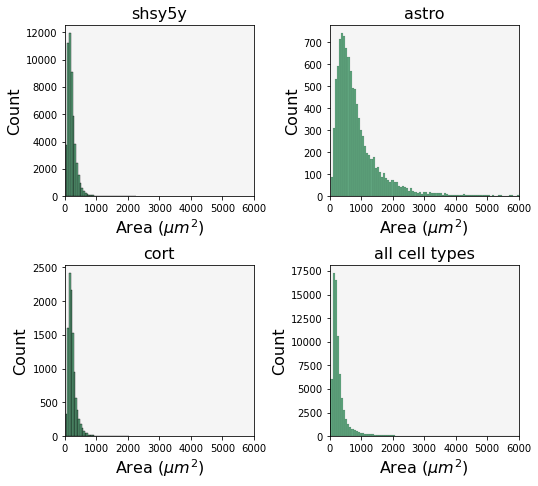

In [150]:
draw_hist_count_vs_area(df_collection, 40)

In [ ]:
# do the same thing to val and test
df_val = c_data.get_annot_in_coco('val')
#df_test = c_data.get_annot_in_coco('test')

val_out_file = str(local_cfg.DATA_DIR / 'competition_in_coco_valid.json')
coco_val_json = c_data.convert_to_coco(df_val, val_out_file)
#test_out_file = str(local_cfg.DATA_DIR / 'competition_in_coco_test.json')
#coco_test_json = c_data.convert_to_coco(df_test, test_out_file)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py

the highest-level keys of metadata is:
dict_keys(['images', 'annotations', 'categories'])
the keys of images in metadata is:
dict_keys(['id', 'file_name', 'height', 'width'])
the keys of annotations in metadata is:
dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd'])
the keys of categories in metadata is:
dict_keys(['supercategory', 'id', 'name'])


#### Check the results of Conversion 
Current dataset in coco format in terms of calculated compressed rle and bbox

In [ ]:
import random

colors = ['limegreen','blue', 'purple', 'red', 'green', 'orange', 'salmon', 'pink']
colors_rgb = [(50, 205, 50), (0, 0, 255), (160, 32, 240), (255, 0, 0),
        (0, 255, 0), (255, 165, 0), (250, 128, 114), (255, 192, 203)]
colors_str_2_rgb = {color_str:color_rgb for color_str, color_rgb in zip(colors, colors_rgb)}


def display_image(images, annots, image_id, show_polys=True, show_bbox=True,
          verbose=False):
    """
    display the image and the corresponding annotations according to the given image_id or the one at random
    :param images: list all images' metadata
    :param annots: list all annots' metadata
    :param image_id: int image id given; or str 'random'
    :param show_polys: boolean flag if polygons should be visualized
    :param show_bbox: boolean flag if bounding box should be visualized
    :param verbose: boolean flag if the additional information should be shown in the terminal
    :return:
    """
    print('Image:')
    print('======')
    if image_id == 'random':
      image_id = random.choice(range(len(images)))
    else:
      image_id = [i for i, image in enumerate(images) if image['id']==image_id][0]

    # Print the image info ##images[image_id]  
    image = images[image_id]
    for key, val in image.items():
        print('  {}: {}'.format(key, val))


    image_path = local_cfg.DATA_DIR / 'train' / image['file_name']
    image = cv2.imread(image_path.as_posix())
    if verbose:
      print('Successfully read the image by cv2')

    # Calculate the size and adjusted display size with aspect ratio being the same
    max_width = 704
    image_height = image.shape[0]
    image_width = image.shape[1]
    adjusted_width = min(image_width, max_width)
    adjusted_ratio = adjusted_width / image_width
    adjusted_height = adjusted_ratio * image_height

    # Create list of polygons to be drawn
    polygons = {}
    bbox_polygons = {}
    rle_regions = {}
    poly_colors = {}
    # Print the annotation info for the specific image id
    annot_in_lst = [annot for annot in annots if annot['image_id']==images[image_id]['id']]
    if verbose:
      print('  one sampled annotation info:')
      pprint.pprint(annot_in_lst[0])

    for i, segm in enumerate(annot_in_lst):
        polygons_list = []

        if verbose:
          # Demonstrate the polygon list having two or more lists if any!
          print('---------------')
          print(np.array(segm['segmentation']))
          print('---------------')
        if len(segm['segmentation']) > 1:
          for sub_seg in segm['segmentation']:
            segmentation_points = int(adjusted_ratio) * np.array([sub_seg])
            segmentation_points = segmentation_points.astype(int)# return np.array([[...]]) (1*m)
            segmentation_points = segmentation_points.reshape((-1, 1, 2))
            polygons_list.append(segmentation_points)
        else:
          segmentation_points = int(adjusted_ratio) * np.array(segm['segmentation'])
          segmentation_points = segmentation_points.astype(int)# return np.array([[...]]) (1*m)
          segmentation_points = segmentation_points.reshape((-1, 1, 2))
          polygons_list.append(segmentation_points)
        polygons[segm['id']] = polygons_list
        poly_colors[segm['id']] = 'limegreen'
        bbox = segm['bbox']
        bbox_points = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1],
                 bbox[0] + bbox[2], bbox[1] + bbox[3],
                 bbox[0], bbox[1] + bbox[3],
                 bbox[0], bbox[1]]
        bbox_points = int(adjusted_ratio) * np.array(bbox_points)
        bbox_points = bbox_points.astype(int)
        bbox_points_unclosed = bbox_points[:-2]
        bbox_polygons[segm['id']] = bbox_points_unclosed.reshape((-1, 1, 2))
        # Print details
        if verbose:
            print('    {}:{}:{}'.format(
                segm['id'], poly_colors[segm['id']]))

    # Draw segmentation polygons on image

    show_polys_begin = time.time()
    if show_polys:
        for seg_id, points_list in polygons.items():
            #fill_color = colors_str_2_rgb[poly_colors[seg_id]]
            fill_color = colors_rgb[0] #limegreen
            image = cv2.fillPoly(image, points_list, fill_color)
    show_polys_end = time.time()
    print(f"Total time of showing polygons is {show_polys_end - show_polys_begin}s.")

    show_bbox_begin = time.time()
    if show_bbox:
        for seg_id, points in bbox_polygons.items():
            #stroke_color = colors_str_2_rgb[poly_colors[seg_id]]
            stroke_color = colors_rgb[-3] #orange
            image = cv2.polylines(image, [points], True, stroke_color, 1)
    show_bbox_end = time.time()
    print(f"Total time of showing bboxes is {show_bbox_end - show_bbox_begin}s.")

    return image

In [ ]:
sample_train_img = display_image(coco_train_json['images'], coco_train_json['annotations'], 
                  'random', show_polys=True, show_bbox=True, # 73508
                  verbose=False)
plt.figure(figsize=(15, 10))
plt.imshow(sample_train_img)
plt.show()

Image:
  id: 46052
  file_name: 9d23373b7bf8.png
  height: 520
  width: 704


UFuncTypeError: ignored

In [ ]:
# an example showing the multiple polygon lists for one polygon annotation
[ann for ann in coco_train_json['annotations'] if ann['image_id'] == 73508 and len(ann['segmentation'])>1]

[{'area': 173.0,
  'bbox': [573.0, 335.0, 20.0, 14.0],
  'category_id': 1,
  'id': 44130,
  'image_id': 73508,
  'iscrowd': 0,
  'segmentation': [[573.0,
    335.0,
    573.0,
    339.0,
    574.0,
    340.0,
    574.0,
    341.0,
    575.0,
    342.0,
    575.0,
    343.0,
    576.0,
    344.0,
    576.0,
    345.0,
    577.0,
    346.0,
    577.0,
    347.0,
    578.0,
    348.0,
    582.0,
    348.0,
    583.0,
    347.0,
    586.0,
    347.0,
    587.0,
    346.0,
    588.0,
    346.0,
    591.0,
    343.0,
    591.0,
    342.0,
    592.0,
    341.0,
    590.0,
    339.0,
    590.0,
    338.0,
    589.0,
    337.0,
    588.0,
    337.0,
    587.0,
    336.0,
    585.0,
    336.0,
    584.0,
    337.0,
    583.0,
    337.0,
    582.0,
    338.0,
    581.0,
    338.0,
    580.0,
    339.0,
    578.0,
    339.0,
    577.0,
    338.0,
    577.0,
    337.0,
    576.0,
    336.0,
    576.0,
    335.0],
   [584.0,
    337.0,
    585.0,
    336.0,
    587.0,
    336.0,
    588.0,
    337.0

In [ ]:
# remove the unused variables w.r.t. the following pipeline for the sake of memory
del coco_train_json
del coco_val_json
del coco_test_json

### Adapt the file structure of images for the sake of using mmdetection

#### Split test dataset into train and val w.r.t images

In [ ]:
livecell_images_train_val_path = livecell_train_val_img_path
livecell_images_test_path = livecell_test_img_path

# 将细胞类型作为key，对应细胞文件名组成的列表作为value，构成一个字典并返回
def getType_imgs(path):
  Type_imgs = {}
  numOfNullList = 0 # 统计有多少个文件夹里是没有文件的，比如这个路径里只有1个
  CellType = os.listdir(path) #['A172', 'BT474', 'BV2', 'Huh7', 'MCF7', 'RatC6', 'SHSY5Y', 'SkBr3', 'SKOV3']
  for idx, infos in enumerate(os.walk(path)):
    tmp_lst = []
    for file in infos[2]:
      tmp_lst.append(file)
    if not tmp_lst:
      numOfNullList += 1
    Type_imgs[CellType[idx - numOfNullList]] = tmp_lst
  return Type_imgs

test_Type_imgs = getType_imgs(livecell_images_test_path)


print(test_Type_imgs.keys())
for key, value in test_Type_imgs.items():
  print(f'The number of {key} is: ', len(value))

dict_keys(['SkBr3', 'A172', 'RatC6', 'SHSY5Y', 'MCF7', 'SKOV3', 'Huh7', 'BT474', 'BV2'])
The number of SkBr3 is:  176
The number of A172 is:  152
The number of RatC6 is:  152
The number of SHSY5Y is:  176
The number of MCF7 is:  184
The number of SKOV3 is:  304
The number of Huh7 is:  200
The number of BT474 is:  168
The number of BV2 is:  152


In [ ]:
# This cell block serves only for extracting tiny dataset
import copy

test_Type_imgs_new = copy.deepcopy(test_Type_imgs)
test_Type_imgs_new.pop('RatC6')
print(test_Type_imgs_new.keys())
for key, value in test_Type_imgs_new.items():
  print(f'The number of {key} is: ', len(value))

train_val_Type_imgs = getType_imgs(livecell_images_train_val_path)
train_val_Type_imgs_new = copy.deepcopy(train_val_Type_imgs)
train_val_Type_imgs_new.pop('RatC6')
print(train_val_Type_imgs_new.keys())
for key, value in train_val_Type_imgs_new.items():
  print(f'The number of {key} is: ', len(value))

dict_keys(['SkBr3', 'A172', 'SHSY5Y', 'MCF7', 'SKOV3', 'Huh7', 'BT474', 'BV2'])
The number of SkBr3 is:  176
The number of A172 is:  152
The number of SHSY5Y is:  176
The number of MCF7 is:  184
The number of SKOV3 is:  304
The number of Huh7 is:  200
The number of BT474 is:  168
The number of BV2 is:  152
dict_keys(['SkBr3', 'A172', 'SHSY5Y', 'MCF7', 'SKOV3', 'Huh7', 'BT474', 'BV2'])
The number of SkBr3 is:  528
The number of A172 is:  456
The number of SHSY5Y is:  528
The number of MCF7 is:  552
The number of SKOV3 is:  304
The number of Huh7 is:  400
The number of BT474 is:  504
The number of BV2 is:  456


In [ ]:
# This cell block serves only for extracting tiny dataset
# check if the specified cell type "RatC6" has the annotations
import json
with open(local_cfg.DATA_DIR/'cache'/'livecell_coco_test.json', 'r') as f:
  train_result_dict = json.load(f)
  sample_cell = 'RatC6'
  sampled_image_ids = [image['id'] for image in train_result_dict['images'] if image['file_name'].split('_')[0]==sample_cell]
#train_result_dict['annotations']
sampled_image_ids

[]

In [ ]:
import random
import json
# 读取文件，返回列表
def _getImagesFileName(json_file_path):
  with open(json_file_path) as json_file:
    livecell = json.load(json_file)
  file_name = [img_info['file_name'] for img_info in livecell['images']]
  return file_name

# 计算训练集所占的比例
def calculate_train_rate(train_json_path, val_json_path):
  train_num = len(_getImagesFileName(train_json_path))
  val_num = len(_getImagesFileName(val_json_path))
  print(val_num)
  print(train_num)
  train_rate = train_num / (train_num + val_num) 
  return train_rate
  

# 根据比例从列表从随机取元素，也就是图片名
def _sample(imgs_lst, rate, splitTest = True):
  assert rate <= 1, "rate should be between 0 and 1 "
  random.shuffle(imgs_lst)
  sample_num = int(len(imgs_lst) * rate)
  if splitTest: # 判断这个采样函数是用于采样测试集还是分割成训练-验证
    return imgs_lst[: sample_num]
  else:
    train_lst, val_lst = imgs_lst[: sample_num], imgs_lst[sample_num: ]
    return train_lst, val_lst

# 用上面的函数在字典里迭代取样，并返回新字典，格式和老字典一样，测试集采样
def SampleTestDict(imgs_dict, rate):
  new_dict = {}
  for img_type, img_lst in imgs_dict.items():
    new_dict[img_type] = _sample(img_lst, rate, True)
  return new_dict

# 将采样后的测试集分成训练以及验证集，返回的字典格式依旧是：{key->Type, value->[file_name]}
def splitTrainVal(imgs_dict, train_rate):
  toTrain_dict = {}
  toVal_dict = {}
  for img_type, img_lst in imgs_dict.items():
    toTrain_dict[img_type], toVal_dict[img_type] = _sample(img_lst, train_rate, False)
  return toTrain_dict, toVal_dict


sample_test_Type_imgs = SampleTestDict(test_Type_imgs, 1) # 采样后的测试集
print(sample_test_Type_imgs.keys())
for key, value in sample_test_Type_imgs.items():
  print(f'The number of {key} is: ', len(value))



LIVECELL_ANN_PATH = os.path.join(local_cfg.DATA_DIR, 'LIVECell_dataset_2021/annotations/LIVECell')
train_json_path = os.path.join(LIVECELL_ANN_PATH, 'livecell_coco_train.json')
val_json_path = os.path.join(LIVECELL_ANN_PATH, 'livecell_coco_val.json')
trainRate = calculate_train_rate(train_json_path, val_json_path)
toTrain_dict, toVal_dict = splitTrainVal(sample_test_Type_imgs, trainRate)
print("Train")
print("================")
for key, value in toTrain_dict.items():
  print(f'The number of {key} is: ', len(value))
print("Val")
print("================")
for key, value in toVal_dict.items():
  print(f'The number of {key} is: ', len(value))

570
3253


**Extract the tiny dataset out of train+val+test**

In [ ]:
tiny_train_val_Type_imgs = SampleTestDict(train_val_Type_imgs_new, 0.02) # 采样后的测试集
print(tiny_train_val_Type_imgs.keys())
for key, value in tiny_train_val_Type_imgs.items():
  print(f'The number of {key} is: ', len(value))

dict_keys(['SkBr3', 'A172', 'SHSY5Y', 'MCF7', 'SKOV3', 'Huh7', 'BT474', 'BV2'])
The number of SkBr3 is:  10
The number of A172 is:  9
The number of SHSY5Y is:  10
The number of MCF7 is:  11
The number of SKOV3 is:  6
The number of Huh7 is:  8
The number of BT474 is:  10
The number of BV2 is:  9


In [ ]:
tiny_train_fn_dict, tiny_val_fn_dict = splitTrainVal(tiny_train_val_Type_imgs, trainRate)
print("Train")
print("================")
for key, value in tiny_train_fn_dict.items():
  print(f'The number of {key} is: ', len(value))
print("Val")
print("================")
for key, value in tiny_val_fn_dict.items():
  print(f'The number of {key} is: ', len(value))
tiny_train_fn_lst = [x for _, values in tiny_train_fn_dict.items() for x in values]
tiny_val_fn_lst = [x for _, values in tiny_val_fn_dict.items() for x in values]

Train
The number of SkBr3 is:  8
The number of A172 is:  7
The number of SHSY5Y is:  8
The number of MCF7 is:  9
The number of SKOV3 is:  5
The number of Huh7 is:  6
The number of BT474 is:  8
The number of BV2 is:  7
Val
The number of SkBr3 is:  2
The number of A172 is:  2
The number of SHSY5Y is:  2
The number of MCF7 is:  2
The number of SKOV3 is:  1
The number of Huh7 is:  2
The number of BT474 is:  2
The number of BV2 is:  2


In [ ]:
tiny_test_Type_imgs = SampleTestDict(test_Type_imgs_new, 0.01) # 采样后的测试集
print(tiny_test_Type_imgs.keys())
for key, value in tiny_test_Type_imgs.items():
  print(f'The number of {key} is: ', len(value))
tiny_test_fn_lst = [x for _, values in tiny_test_Type_imgs.items() for x in values]

dict_keys(['SkBr3', 'A172', 'SHSY5Y', 'MCF7', 'SKOV3', 'Huh7', 'BT474', 'BV2'])
The number of SkBr3 is:  1
The number of A172 is:  1
The number of SHSY5Y is:  1
The number of MCF7 is:  1
The number of SKOV3 is:  3
The number of Huh7 is:  2
The number of BT474 is:  1
The number of BV2 is:  1


In [ ]:
def extract_tiny_annots(ann_file, out_file, fns):
  """
  add the test anns to the train/val anns and store the exteneded
  :param dst_ann_file Path train/val annotation file
  :param test_ann_file Path test annotation file
  :param out_file Path file path for storing
  :param fns list list containing the candidate filenames
  :return: dict extended annotation train+ / val+
  """
  file_format = ann_file.split('.')[-1]
  data_infos = mmcv.load(ann_file, file_format=file_format)
  images_len = len(data_infos['images'])
  annots_len = len(data_infos['annotations'])

  temp_images = []
  temp_image_ids = []
  temp_annotations = []
  obj_count = 0 

  # extract the image and annotation items out of test_data_infos and
  # assign them all to a temporary list respectively
  for par_key, par_value in mmcv.track_iter_progress(data_infos.items()):
    if par_key == 'images':
      for value in par_value:
        if value['file_name'] in fns:
          temp_images.append(value)
          temp_image_ids.append(value['id'])
    else:
      pass

  for par_key, par_value in mmcv.track_iter_progress(data_infos.items()):
    if par_key == 'annotations':
      for value in par_value:
        if value['image_id'] in temp_image_ids:
          data_anno = dict(
                image_id=int(value['image_id']),
                id=obj_count,
                category_id=1,
                bbox=value['bbox'],
                area=float(value['area']),
                segmentation=value['segmentation'],
                iscrowd=0)
          temp_annotations.append(data_anno)
          obj_count += 1
    elif par_key == 'categories':
      categories=par_value
    else:
      pass
  
  coco_format_json = dict(
        images=temp_images,
        annotations=temp_annotations,
        categories=categories)
  print(f'result images: {len(temp_images)}')
  print(f'result annots: {len(temp_annotations)}')

  mmcv.dump(coco_format_json, out_file) 
  return coco_format_json

train_ann_file = str(local_cfg.DATA_DIR / 'cache' / 'livecell_coco_train.json')
val_ann_file = str(local_cfg.DATA_DIR / 'cache' / 'livecell_coco_val.json')
test_ann_file = str(local_cfg.DATA_DIR / 'cache' / 'livecell_coco_test.json')
tiny_train_ann_file = str(local_cfg.DATA_DIR / 'cache' / 'livecell_coco_train_tiny.json')
tiny_val_ann_file = str(local_cfg.DATA_DIR / 'cache' / 'livecell_coco_val_tiny.json')
tiny_test_ann_file = str(local_cfg.DATA_DIR / 'cache' / 'livecell_coco_test_tiny.json')


In [ ]:
tiny_train_result_dict = extract_tiny_annots(train_ann_file, tiny_train_ann_file, tiny_train_fn_lst)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 182.5 task/s, elapsed: 0s, ETA:     0s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 1.3 task/s, elapsed: 2s, ETA:     0s
result images: 53
result annots: 13371


In [ ]:
tiny_val_result_dict = extract_tiny_annots(val_ann_file, tiny_val_ann_file, tiny_val_fn_lst)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 350.6 task/s, elapsed: 0s, ETA:     0s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 46.5 task/s, elapsed: 0s, ETA:     0s
result images: 3
result annots: 749


In [ ]:
tiny_test_result_dict = extract_tiny_annots(test_ann_file, tiny_test_ann_file, tiny_test_fn_lst)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 299.7 task/s, elapsed: 0s, ETA:     0s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 8.4 task/s, elapsed: 0s, ETA:     0s
result images: 11
result annots: 2128


#### Split test into train and val w.r.t. annotations

In [ ]:
fns_for_train=[x for _, values in toTrain_dict.items() for x in values]
fns_for_val=[x for _, values in toVal_dict.items() for x in values]
print(len(fns_for_train))
print(len(fns_for_val))

In [ ]:
def append_livecell_test_coco(dst_ann_file, test_ann_file, out_file, fns):
  """
  add the test anns to the train/val anns and store the exteneded
  :param dst_ann_file Path train/val annotation file
  :param test_ann_file Path test annotation file
  :param out_file Path file path for storing
  :param fns list list containing the candidate filenames
  :return: dict extended annotation train+ / val+
  """
  file_format = dst_ann_file.split('.')[-1]
  dst_data_infos = mmcv.load(dst_ann_file, file_format=file_format)
  dst_images_len = len(dst_data_infos['images'])
  dst_annots_len = len(dst_data_infos['annotations'])
  test_data_infos = mmcv.load(test_ann_file, file_format=file_format)

  temp_images = []
  temp_image_ids = []
  temp_annotations = []
  obj_count = len(dst_data_infos['annotations']) # equivalent to end NO + 1

  # extract the image and annotation items out of test_data_infos and
  # assign them all to a temporary list respectively
  for par_key, par_value in mmcv.track_iter_progress(test_data_infos.items()):
    if par_key == 'images':
      for value in par_value:
        if value['file_name'] in fns:
          temp_images.append(value)
          temp_image_ids.append(value['id'])
    else:
      pass

  for par_key, par_value in mmcv.track_iter_progress(test_data_infos.items()):
    if par_key == 'annotations':
      for value in par_value:
        if value['image_id'] in temp_image_ids:
          data_anno = dict(
                image_id=int(value['image_id']),
                id=obj_count,
                category_id=1,
                bbox=value['bbox'],
                area=float(value['area']),
                segmentation=value['segmentation'],
                iscrowd=0)
          temp_annotations.append(data_anno)
          obj_count += 1
    else:
      pass
  
  dst_data_infos['images'].extend(temp_images)
  dst_data_infos['annotations'].extend(temp_annotations)
  print(f'test for dest images: {len(temp_images)}')
  print(f'dest images: {dst_images_len}')
  print(f"result images: {len(dst_data_infos['images'])}")
  print(f'test for dest annots: {len(temp_annotations)}')
  print(f'dest annots: {dst_annots_len}')
  print(f"result annots: {len(dst_data_infos['annotations'])}")

  assert len(dst_data_infos['images']) == dst_images_len + len(temp_images), "images extension doesn't succeed due to missing items."
  assert len(dst_data_infos['annotations']) == dst_annots_len + len(temp_annotations), "annotations extension doesn't succeed due to missing items."

  mmcv.dump(dst_data_infos, out_file) 
  return dst_data_infos


test_ann_file = str(local_cfg.DATA_DIR / 'cache' / 'livecell_coco_test.json')

# append one test part to train
train_ann_file = str(local_cfg.DATA_DIR / 'cache' / 'livecell_coco_train.json')
new_train_ann_file = str(local_cfg.DATA_DIR / 'cache' / 'livecell_coco_train_new.json')
new_train_result_dict = append_livecell_test_coco(train_ann_file, test_ann_file, new_train_ann_file, fns_for_train)
print(f"the new train metadata has {len(new_train_result_dict['images'])} \
   images and {len(new_train_result_dict['annotations'])} annotations")
del new_train_result_dict

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 106.7 task/s, elapsed: 0s, ETA:     0s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 0.5 task/s, elapsed: 6s, ETA:     0s
test for dest images: 1324
dest images: 3253
result images: 4577
test for dest annots: 390740
dest annots: 1018576
result annots: 1409316
the new train metadata has 4577    images and 1409316 annotations


In [ ]:
# append the other test part to train
val_ann_file = str(local_cfg.DATA_DIR / 'cache' / 'livecell_coco_val.json')
new_val_ann_file = str(local_cfg.DATA_DIR / 'cache' / 'livecell_coco_val_new.json')
new_val_result_dict = append_livecell_test_coco(val_ann_file, test_ann_file, new_val_ann_file, fns_for_val)
print(f"the new train metadata has {len(new_val_result_dict['images'])} \
   images and {len(new_val_result_dict['annotations'])} annotations")
del new_val_result_dict

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 214.8 task/s, elapsed: 0s, ETA:     0s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 1.6 task/s, elapsed: 2s, ETA:     0s
test for dest images: 240
dest images: 570
result images: 810
test for dest annots: 71521
dest annots: 181610
result annots: 253131
the new train metadata has 810    images and 253131 annotations


### Adapt the file structure of images for the sake of using mmdetection

In [ ]:
import shutil

target_path = os.path.join(local_cfg.DATA_DIR, 'cache/livecell_images')
CellType = ['A172', 'BT474', 'BV2', 'Huh7', 'MCF7', 'RatC6', 'SHSY5Y', 'SkBr3', 'SKOV3']

# 从路径中读取所有的图片名，也就是在这一步去除了那些细胞类型的文件夹
def getAllImageFileName(images_path):
  raw_all_imgs = []
  for _, _, files in os.walk(images_path):
    raw_all_imgs.append(files)
  all_imgs = [img for img_lst in raw_all_imgs for img in img_lst]
  return all_imgs

# 将所有图片(train & val & test)拷贝到目标路径
def saveImages(imgs, OrignalPath, TargetPath = target_path):
  """
  imgs(list): names of images
  OrignalPath(str): orignal path of images
  TargetPath(str): target path that save the images
  """
  dir_lsts = [os.path.join(OrignalPath, cell) for cell in CellType]
  origin_no = len([name for sub_dir in dir_lsts for name in os.listdir(sub_dir) if os.path.isfile(os.path.join(sub_dir, name))])
  print(f"original files have {origin_no} images")
  for img in imgs:
    celltype = img.split('_')[0]
    full_name = os.path.join(OrignalPath, f'{celltype}/{img}')
    shutil.move(full_name, TargetPath)
  current_no = len([name for name in os.listdir(TargetPath) if os.path.isfile(os.path.join(TargetPath, name))])
  print(f"current files have {current_no} images")
  assert origin_no==current_no, "files missing when moving them!"


train_val_imgs = getAllImageFileName(livecell_train_val_img_path)  # obtain the images_names from path
test_imgs = getAllImageFileName(livecell_test_img_path)

saveImages(train_val_imgs, livecell_train_val_img_path, target_path)       # save the images to target path
saveImages(test_imgs, livecell_test_img_path, target_path)

original files have 4184 images
current files have 4184 images
original files have 1664 images
current files have 5848 images


AssertionError: ignored

In [ ]:
# check if all files are moved to the dest
len([name for name in os.listdir(target_path)])

5848

In [ ]:
!zip -r /content/data/cache/livecell_images.zip /content/data/cache/livecell_images

流式输出内容被截断，只能显示最后 5000 行内容。
  adding: content/data/cache/livecell_images/SkBr3_Phase_G3_2_02d20h00m_1.tif (deflated 4%)
  adding: content/data/cache/livecell_images/Huh7_Phase_A12_2_00d16h00m_1.tif (deflated 1%)
  adding: content/data/cache/livecell_images/BT474_Phase_C3_2_02d00h00m_1.tif (deflated 2%)
  adding: content/data/cache/livecell_images/BT474_Phase_A3_2_03d00h00m_1.tif (deflated 3%)
  adding: content/data/cache/livecell_images/Huh7_Phase_A10_1_01d20h00m_2.tif (deflated 2%)
  adding: content/data/cache/livecell_images/BV2_Phase_C4_1_01d20h00m_3.tif (deflated 3%)
  adding: content/data/cache/livecell_images/BT474_Phase_A3_2_00d00h00m_1.tif (deflated 2%)
  adding: content/data/cache/livecell_images/Huh7_Phase_A10_2_03d16h00m_4.tif (deflated 1%)
  adding: content/data/cache/livecell_images/RatC6_Phase_E4_2_02d04h00m_3.tif (deflated 2%)
  adding: content/data/cache/livecell_images/SHSY5Y_Phase_C10_1_00d04h00m_4.tif (deflated 1%)
  adding: content/data/cache/livecell_images/A172_Pha